In [1]:
#import csv
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
np.random.seed(42)

In [7]:
'''
-------------------------
Basic ML helper functions
-------------------------
'''

def mse(y_act,y_pred):
    '''mean square error helper function'''
    return np.mean((y_act-y_pred)**2)

def r_squared(y_act,y_pred):
    '''r-squared statistic for explaining variance'''
    return 1-np.mean((y_act-y_pred)**2)/np.var(y_act)

def sq_dist(X,Z):
    '''
    fancy vectorized code for computing squared Euclidean distance
    inputs: (X,Z) matrices with same number of columns
    outputs: matrix D with entries D[i,j] = ||X[i,:]-Z[j,:]||^2
    '''
    return np.add.outer((X**2).sum(1),(Z**2).sum(1))-2*X@Z.T

def sq_dist_for(X,Z):
    '''
    unfancy readable for loop code for computing squared Euclidean distance
    '''
    R = np.zeros((X.shape[0],Z.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Z.shape[0]):
            for k in range(X.shape[1]):
                R[i,j]+=(X[i,k]-Z[i,k])**2
    return R

def gaussian_kernel(X,Z,scale):
    '''
    function to compute the Gaussian kernel matrix associating X and Z.
    K[i,j] = exp(-scale*||X[i,:]-Z[j,:]||^2)
    '''
    sq_dist_mat = sq_dist(X,Z)
    return np.exp(-scale*sq_dist_mat)

def poly_kernel(X,Z,degree,scale):
    '''
    function to compute the polynomial kernel matrix associating X and Z.
    K[i,j] = (1+scale*X[i,:]*Z[j,:].T||)^degree
    '''
    return (1+scale*X.dot(Z.T))**degree

'''
-------------------
Training functions
-------------------
'''

def least_squares_train(X,y):
    '''Find the least-squares solution: minimize_w ||Xw-y||'''
    return scipy.linalg.solve((X.T).dot(X),(X.T).dot(y))

def kernel_ridge_train(K,y,reg_param):
    '''Computes Kernel ridge regression solution (K+reg_param*I)^(-1)y'''
    return scipy.linalg.solve(K+reg_param*np.eye(K.shape[0]),y)

'''
-------------------------------------------
Cross Validation and associated subroutines
--------------------------------------------
'''

def crossval(X,y,eval_train_test,nfolds,params):
    '''
    Cross validation routine. Inputs
        X - training data matrix
        y - training labels
        eval_train_test - routine that takes a train set, test set, and parameters and returns average loss
        nfolds - number of folds
        params - matrix of parameters for eval_train_test. each row is a set of parameters.
    Returns: estimate of average loss by cross validation
    '''
    
    N = X.shape[0]
        
    myfolds = np.random.permutation(N)
    myfolds = [myfolds[i::nfolds] for i in range(nfolds)]
    
    metric = np.zeros((params.shape[0]))
    count = 0
    for fold in myfolds:
        print("fold {}".format(count+1))
        X_train = X[np.setdiff1d(range(N),fold),:]
        y_train = y[np.setdiff1d(range(N),fold)]
        X_test = X[fold,:]
        y_test = y[fold]
        count += 1
        for param in range(params.shape[0]):
            metric[param] += eval_train_test(X_train,y_train,X_test,y_test,params[param,:])
        
    return metric/count

'''Evaluation functions for different feature sets'''
def lsq_eval_train_test(X_train,y_train,X_test,y_test):
    w = least_squares_train(X_train,y_train)
    y_pred = X_test.dot(w)
    return mse(y_test,y_pred)

def gauss_krr_eval_train_test(X_train,y_train,X_test,y_test,param):
    reg_param = param[0]
    scale = param[1]
    K = gaussian_kernel(X_train,X_train,scale)
    c = kernel_ridge_train(K,y_train,reg_param)
    K_test = gaussian_kernel(X_test,X_train,scale)
    y_pred = K_test.dot(c)
    return mse(y_test,y_pred)

def qpoly_krr_eval_train_test(X_train,y_train,X_test,y_test,param):
    reg_param = param[0]
    pscale = param[1]
    K = poly_kernel(X_train,X_train,2,pscale)
    c = kernel_ridge_train(K,y_train,reg_param)
    K_test = poly_kernel(X_test,X_train,2,pscale)
    y_pred = K_test.dot(c)
    return mse(y_test,y_pred)

'''
---------------------
Plotting Subroutines
----------------------
'''
def scatter_preds(y_true,y_preds,ax=None,c=None,s=None):
    '''give a scatter plot of predicted vs. actual values'''
    if ax == None:
        fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(y_preds,y_true,alpha=0.7,c='b',s=s)
    ax.plot([min(y_true),max(y_true)],[min(y_true),max(y_true)],color='k',linestyle='--',linewidth=3)

    ax.set_aspect("equal")
    ax.set_xlabel("predicted", fontsize=20)
    ax.set_ylabel("actual", fontsize=20)
    plt.xticks(fontsize = 20) # work on current fig
    plt.yticks(fontsize = 20) # work on current fig

## Boston House Price Data Set

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management,  vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 1980.   N.B. Various transformations are used in the table on pages 244-261 of the latter.

 Variables in order:
 * CRIM - per capita crime rate by town
 * ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
 * INDUS - proportion of non-retail business acres per town
 * CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 * NOX - nitric oxides concentration (parts per 10 million)
 * RM - average number of rooms per dwelling
 * AGE - proportion of owner-occupied units built prior to 1940
 * DIS - weighted distances to five Boston employment centres
 * RAD - index of accessibility to radial highways
 * TAX - full-value property-tax rate per \$10,000
 * PTRATIO - pupil-teacher ratio by town
 * B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town (!!!)
 * LSTAT - % lower status of the population
 * MEDV - Median value of owner-occupied homes in \$1000's
 
**The goal will be to predict MEDV from the other variables.**


### First we load and process the data from a csv file

In [3]:
df = pd.read_csv('boston_housing.csv')
df[:5]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
# Extract data from dataframe and convert it to a numpy array of features and targets
data = df.values

X = data[:,0:13]
X[:,11]=.63-np.sqrt(X[:,11]/1000)

y = data[:,13]

N=X.shape[0]
NFeat = X.shape[1]

### Next we split the data into a train set and test set
We use an 80-20 split.

In [5]:
N = X.shape[0]

N_Train = np.floor(0.8*N).astype(int)
myperm = np.random.permutation(N)
idx_train = myperm[0:N_Train]
idx_test = myperm[N_Train:N]

X_train = X[idx_train,:]
y_train = y[idx_train]

X_test = X[idx_test,:]
y_test = y[idx_test]

### Linear Regression

Linear Regression
 R2 = 0.68 
 MSE = 2.26e+01


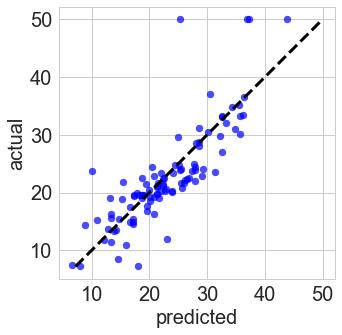

In [8]:
X_train_l = np.hstack((X_train,np.ones((X_train.shape[0],1))))
X_test_l = np.hstack((X_test,np.ones((X_test.shape[0],1))))

w = least_squares_train(X_train_l,y_train)
y_pred = X_test_l.dot(w)

print("Linear Regression\n R2 = {0:.2f} \n MSE = {1:.2e}".format(
                           r_squared(y_test,y_pred),
                           mse(y_test,y_pred)))

scatter_preds(y_test,y_pred)

In [9]:
r_squared(y_train,X_train_l.dot(w))

0.7456420203441383

### Gaussian Kernel Ridge Regression

Compute parameters using cross validation:

In [10]:
# heuristic for computing the bandwidth of the Gaussian kernel
# this is an incredibly useful heuristic!!!
R = sq_dist(X_train,X_train)
scale_mid = 1/np.median(R)

# make a grid of parameters to try for cross validation
nscales = 10
nregs = 10
minreg = -8
maxreg = 1
minscale = np.log10(scale_mid)-1
maxscale = np.log10(scale_mid)+1

regs, scales = np.meshgrid(np.logspace(minreg,maxreg,nregs), np.logspace(minscale,maxscale,nscales),
                           sparse=False, indexing='ij')
params = np.hstack((regs.reshape(nregs*nscales,1),scales.reshape(nregs*nscales,1)))

### cross validation
mse_vals = crossval(X_train,y_train,gauss_krr_eval_train_test,10,params)
minimizer = np.argmin(mse_vals)
print("reg_param : {0:.2e}, scale : {1:.2e}\n".format(params[minimizer,0],params[minimizer,1]))

fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
reg_param : 1.00e-05, scale : 5.02e-06



Gaussian Kernel
 R2 = 0.84 
 MSE = 1.15e+01


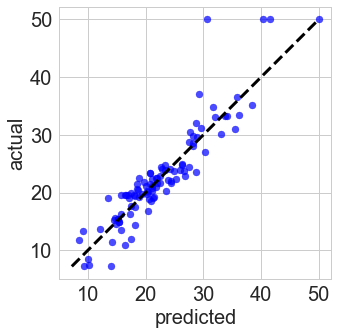

In [11]:
scale = params[minimizer,1]
reg_param = params[minimizer,0]

K = gaussian_kernel(X_train,X_train,scale) 
c = kernel_ridge_train(K,y_train,reg_param)
K_test = gaussian_kernel(X_test,X_train,scale)
y_pred = K_test.dot(c)

print("Gaussian Kernel\n R2 = {0:.2f} \n MSE = {1:.2e}".format(
                           r_squared(y_test,y_pred),
                           mse(y_test,y_pred)))

scatter_preds(y_test,y_pred)

### Gaussian Kernel Ridge Regression with preprocessing

Preprocess the data so that the features each have mean zero and unit variance

In [14]:
mu_train = np.mean(X_train,axis=0)
var_train = np.mean((X_train-mu_train[None,:])**2,axis = 0)

X_train_scale = (X_train-mu_train[None,:])/np.sqrt(var_train[None,:])
X_test_scale = (X_test-mu_train[None,:])/np.sqrt(var_train[None,:])

Compute parameters using cross validation:

In [15]:
R = sq_dist(X_train_scale,X_train_scale)
scale_mid = 1/np.median(R)

# make a grid of parameters to try for cross validation
nscales = 10
nregs = 10
maxreg = 1
minreg = -8
maxscale = np.log10(scale_mid)+1
minscale = np.log10(scale_mid)-1

regs, scales = np.meshgrid(np.logspace(minreg,maxreg,nregs), np.logspace(minscale,maxscale,nscales),
                           sparse=False, indexing='ij')
params = np.hstack((regs.reshape(nregs*nscales,1),scales.reshape(nregs*nscales,1)))

### cross validation
mse_vals = crossval(X_train_scale,y_train,gauss_krr_eval_train_test,10,params)
minimizer = np.argmin(mse_vals)
print("reg_param : {0:.2e}, scale : {1:.2e}\n".format(params[minimizer,0],params[minimizer,1]))

fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
reg_param : 1.00e-02, scale : 2.07e-02



Gaussian Kernel, normalized data
 R2 = 0.86 
 MSE = 1.01e+01


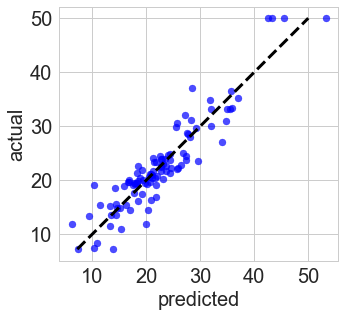

In [16]:
scale = params[minimizer,1]
reg_param = params[minimizer,0]

K = gaussian_kernel(X_train_scale,X_train_scale,scale) 
c = kernel_ridge_train(K,y_train,reg_param)
K_test = gaussian_kernel(X_test_scale,X_train_scale,scale)
y_pred = K_test.dot(c)

print("Gaussian Kernel, normalized data\n R2 = {0:.2f} \n MSE = {1:.2e}".format(
                           r_squared(y_test,y_pred),
                           mse(y_test,y_pred)))

scatter_preds(y_test,y_pred)

### Quadratic Polynomial Kernel Ridge Regression

In [ ]:
# heuristic to set scale of polynomial kernel
pscale_base = 1/np.max(np.sum(X_train**2,axis=1))
print("heuristic scale : {0:.2e}".format(scale_mid))

# make a grid of parameters to try for cross validation
nscales = 10
nregs = 10
maxreg = 1
minreg = -8
maxscale = np.log10(pscale_base)+1
minscale = np.log10(scale_mid)-1

regs, scales = np.meshgrid(np.logspace(minreg,maxreg,nregs), np.logspace(minscale,maxscale,nscales),
                           sparse=False, indexing='ij')
params = np.hstack((regs.reshape(nregs*nscales,1),scales.reshape(nregs*nscales,1)))

### cross validation
mse_vals = crossval(X_train_scale,y_train,qpoly_krr_eval_train_test,10,params)
minimizer = np.argmin(mse_vals)
print("reg_param : {0:.2e}, scale : {1:.2e}\n".format(params[minimizer,0],params[minimizer,1]))

In [ ]:
pscale = params[minimizer,1]
reg_param = params[minimizer,0]

K = (1+pscale*X_train.dot(X_train.T))**2
c = kernel_ridge_train(K,y_train,reg_param)

K_test=(1+pscale*X_test.dot(X_train.T))**2
y_pred = K_test.dot(c)

print("Polynomial Kernel\n R2 = {0:.2f} \n MSE = {1:.2e}".format(
                           r_squared(y_test,y_pred),
                           mse(y_test,y_pred)))

scatter_preds(y_test,y_pred)

In [12]:
%timeit sq_dist(X,X)

672 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit sq_dist_for(X,X)

2.52 s ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
